# Monte Carlo Valuation of European call option in GBM model

In [1]:
#Functions and Libraries
from scipy import stats
import numpy as np
from time import time

In [2]:
# Parameters of the model
S = 100.0 #Initial stock price
sigma = 0.3 #Volatility
r = 0.02 #risk-free interest rate
T = 1.0 #Maturity time
K = 95.0 #Strike price

In [3]:
def NCDF(x): return stats.norm.cdf(x, 0.0, 1.0) 
def INCDF(u): return stats.norm.ppf(u)

In [4]:
NCDF(INCDF(0.975))

0.97499999999999998

In [5]:
def CallVal(S,T,K,r,sigma):
    d_plus = ( np.log(S / K) + ( r + 0.5 * sigma ** 2) * T ) / ( sigma * np.sqrt(T) )
    d_minus = d_plus - sigma * np.sqrt(T)
    val = S * NCDF(d_plus) -  K * np.exp(-r * T) * NCDF(d_minus)
    return val

In [6]:
CallVal(S,T,K,r,sigma)

15.274859561935457

In [7]:
def Call_Payoff(S,K): return np.fmax(S-K,0.0)
def Put_Payoff(S,K): return np.fmax(K-S,0.0)

In [8]:
def CrudeMCM(M,S,K,T,r,sigma,Payoff):
    Z = np.random.standard_normal(M) #Std. Normal samples
    ST = S * np.exp((r - 0.5 * sigma ** 2 ) * T 
                + sigma * np.sqrt(T) * Z) #Lognormal Samples
    DCPV = np.exp(-r * T) * Payoff(ST,K)
    sample_mean = np.mean(DCPV)
    std_error = np.std(DCPV)/np.sqrt(M)
    return sample_mean,std_error,ST,DCPV

In [9]:
t0 = time()
M = 1000000 #Number of realizations
(sample_mean,std_error,ST,DCPV) = CrudeMCM(M,S,K,T,r,sigma,Call_Payoff)
lep = sample_mean - 1.96 * std_error
rep = sample_mean + 1.96 * std_error
print "The MCM estimate of the call value is %f" % sample_mean
print "The standard error of the estimate is", std_error
print "The 95%% confidence interval is (%8.4f , %8.4f )" % (lep, rep)
print "Time is %f sec" % (time()-t0)

The MCM estimate of the call value is 15.254193
The standard error of the estimate is 0.0231400076689
The 95% confidence interval is ( 15.2088 ,  15.2995 )
Time is 0.081345 sec


In [10]:
def LNpdf(x,S,r,sigma,t):
    sigma2 = sigma**2
    val = np.exp(-0.5*(np.log(x/S)-(r-0.5*sigma2))**2/(sigma2*t))
    val = val / (sigma*x*np.sqrt(2*np.pi*t))
    return val

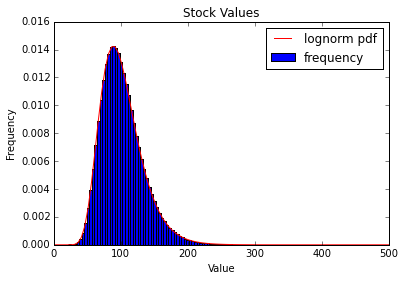

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(ST,100,normed=1,label='frequency')
plt.title("Stock Values")
plt.xlabel("Value")
plt.ylabel("Frequency")
x = np.linspace(1,500,100)
y = LNpdf(x,S,r,sigma,T)
plt.plot(x, y,'r-', label='lognorm pdf')
plt.legend()
plt.show()

In [12]:
csums = np.cumsum(DCPV)
estimates = csums / range(1,M+1)
callval = np.ones(M)*CallVal(S,T,K,r,sigma)

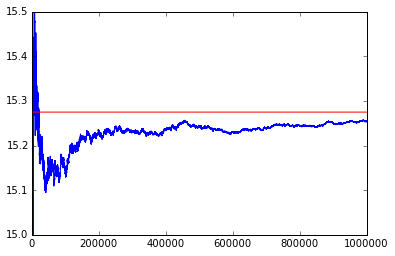

In [13]:
n = range(M)
plt.plot(n[100:],estimates[100:])
plt.plot(n[100:],callval[100:],'r-')
plt.ylim([15.0,15.5])
plt.show()

In [14]:
def AntVarMCM(M,S,K,T,r,sigma,Payoff):
    Z = np.random.standard_normal(M) #Std. Normal samples
    ST = S * np.exp((r - 0.5 * sigma ** 2 ) * T 
                + sigma * np.sqrt(T) * Z) #Lognormal Samples
    STA = S * np.exp((r - 0.5 * sigma ** 2 ) * T 
                - sigma * np.sqrt(T) * Z) #Lognormal Samples
    DCPV = np.exp(-r * T) * (Payoff(ST,K)+Payoff(STA,K))*0.5
    sample_mean = np.mean(DCPV)
    std_error = np.std(DCPV)/np.sqrt(M)
    return sample_mean,std_error

In [15]:
t0 = time()
M = 1000000 #Number of realizations
(sample_mean,std_error) = AntVarMCM(M,S,K,T,r,sigma,Call_Payoff)
lep = sample_mean - 1.96 * std_error
rep = sample_mean + 1.96 * std_error
print "The MCM estimate of the call value is %f" % sample_mean
print "The standard error of the estimate is", std_error
print "The 95%% confidence interval is (%8.4f , %8.4f )" % (lep, rep)
print "Time is %f sec" % (time()-t0)

The MCM estimate of the call value is 15.282710
The standard error of the estimate is 0.0123004981993
The 95% confidence interval is ( 15.2586 ,  15.3068 )
Time is 0.104384 sec


In [16]:
def SampleCondNorm(a,N):
    #Sample a std. norm Z conditional on Z>a
    U = np.random.rand(N)
    na = NCDF(a)
    Z = INCDF(na+(1.0-na)*U)
    return Z

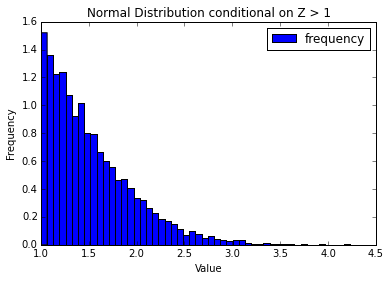

In [17]:
Z = SampleCondNorm(1,10000)
plt.hist(Z,50,normed=1,label='frequency')
plt.title("Normal Distribution conditional on Z > 1")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [18]:
def CondMCM(M,S,K,T,r,sigma,Payoff):
    d_minus = ( np.log(S / K) + ( r - 0.5 * sigma ** 2) * T ) / ( sigma * np.sqrt(T) )
    Z = SampleCondNorm(-d_minus,M) #Cond. Normal samples
    ST = S * np.exp((r - 0.5 * sigma ** 2 ) * T 
                + sigma * np.sqrt(T) * Z) #Lognormal Samples
    d_minus = ( np.log(S / K) + ( r - 0.5 * sigma ** 2) * T ) / ( sigma * np.sqrt(T) )
    DCPV = np.exp(-r * T) * Payoff(ST,K) * NCDF(d_minus)
    sample_mean = np.mean(DCPV)
    std_error = np.std(DCPV)/np.sqrt(M)
    return sample_mean,std_error

In [19]:
t0 = time()
M = 1000000 #Number of realizations
(sample_mean,std_error) = CondMCM(M,S,K,T,r,sigma,Call_Payoff)
lep = sample_mean - 1.96 * std_error
rep = sample_mean + 1.96 * std_error
print "The MCM estimate of the call value is %f" % sample_mean
print "The standard error of the estimate is", std_error
print "The 95%% confidence interval is (%8.4f , %8.4f )" % (lep, rep)
print "Time is %f sec" % (time()-t0)

The MCM estimate of the call value is 15.280483
The standard error of the estimate is 0.0133359529584
The 95% confidence interval is ( 15.2543 ,  15.3066 )
Time is 0.187737 sec
